<h1>
Scikit-Learn GP Regression Notebook
</h1>

<p>
The purpose of this notebook is to evaluate the feasability of using Scikit-learn module for regression in radiation modelling over a costmap 
</p>


In [4]:
#Import all libraries and establish important variables/constants

import numpy as np
import pandas as pd

import yaml
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import imageio as im

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, Sum
from sklearn.model_selection import train_test_split

#Loads in the data and takes random samples where 70% is used for training and 30% for testing/validation
data_raw = np.array(pd.read_csv("TrainingData\\Radiation_Data(Rad_Test_#1 with cpm).csv",sep=","))
#data_raw = np.array(pd.read_csv("TrainingData\\Radiation_Data(Background_#1).csv",sep=","))
XY = np.array(data_raw[:,0:2])
Counts = (np.array([data_raw[:,3]]).T)
(XY_train, XY_test, Counts_train, Counts_test) = train_test_split(XY, Counts, test_size=.3, random_state=42)

#creates a grid_length*2 matrix to represent the cost map coordinates which is used for predicicting count coverage over entierty of costmap

print("Data Loaded and Mesh Grid created")


Data Loaded and Mesh Grid created


In [5]:
#Setting Up GP Regression

Counts_mean = Counts_train.mean()
#below values are known to work well
#c = 0.6, ls = 0.5, n =1.1
const = 5
ls = 1
n = 1.2
Kernel = Sum(ConstantKernel(constant_value=const),Matern(length_scale=ls,nu=n))



#regressor = GaussianProcessRegressor(kernel=Kernel).fit(XY_train,(Counts_train-Counts_mean))
regressor = GaussianProcessRegressor(kernel=Kernel, n_restarts_optimizer=500, normalize_y=False,alpha=1)
#minuses the mean as zero mean is ideal for training gaussian processes
regressor.fit(XY_train,(Counts_train-Counts_mean))

print("Regressor has been Fitted to training Data")

(X_max, Y_max) = np.max(XY,axis=0)
(X_min, Y_min) = np.min(XY,axis=0)
grid_length = 125
X_lin = np.linspace(X_min,X_max, grid_length)
Y_lin = np.linspace(Y_min,Y_max, grid_length)

grid_x, grid_y = np.meshgrid(X_lin, Y_lin)
coords = np.vstack([np.ravel(grid_x),np.ravel(grid_y)]).T
(Counts_mean_pred, Counts_std_pred) = regressor.predict(coords,return_std=True)


print("Costmap has been filled with Count data")
Counts_mean_pred += Counts_mean
Counts_mean_pred = Counts_mean_pred.reshape(grid_length,grid_length)


c:\Users\aidan\miniconda3\envs\SkLearnEnv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Regressor has been Fitted to training Data
Costmap has been filled with Count data


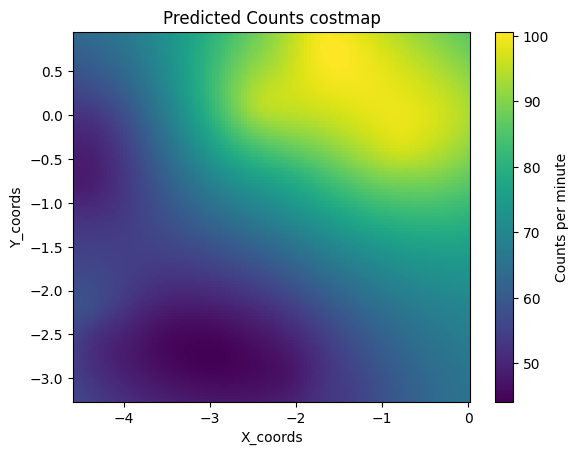

Score is: 39.79%


In [6]:
fig, ax = plt.subplots()

c = ax.pcolor(X_lin, Y_lin, Counts_mean_pred)
ax.set_title("Predicted Counts costmap")
cbar = fig.colorbar(c)
cbar.set_label("Counts per minute")

ax.set_xlabel('X_coords')
ax.set_ylabel('Y_coords')

plt.show()
score = regressor.score(XY_test, Counts_test-Counts_test.mean())
print(f"Score is: {score:.2%}")
gray_array = Counts_mean_pred*(255/20)
gray_array = gray_array.astype(np.uint8)
file_name = f"GP Regression Results\\greyscale_costmap,c+{const},ls={ls},n={n}.pgm"
im.imwrite(file_name, gray_array, format="pgm")